# Title: Finding Most Informative Variables in Predicting Flight Delay

### Name: Bilge Elitok


In [1]:
import numpy as np
import seaborn as sns
import os 
import networkx as nx
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import gravis as gv #Viz embeding


### 1. Load the Dataset and Return the Summary

In [2]:
def load_data(path_list, null_threshold):
    """Load data from paths and summarize key information.

    args
    path_list(list):        list of where .csv files are located
    null_threshold(float):  columns that has null value percentage exceeds this number will be returned

    returns
    List of the objects that store the input data
    Summary Table for the files.
    
    """


    for path in path_list:
        # Extract file name without extension:

        #DepDelay Related Columns List:


        # Convert to pandas DataFrame
        df = pd.read_csv(path)


        # Gather data information
        row_count, column_count = df.shape[0], df.shape[1]
        null_count = df.isnull().sum().sum()  # Total null count
        null_columns = [(col, count) for col, count in df.isnull().sum().items() if count < 0]

        # Columns with more than the null threshold
        percentage_null = (df.isnull().sum() / len(df)) * 100
        columns_above_threshold = percentage_null[percentage_null > null_threshold]

        # Save DataFrame and its summary
        dataframes[file_name] = df

        # Dynamic Variable Assignment for accesing dataframes outside the function.
        for name, df in dataframes.items():
            globals()[name] = df

        dataframes_summary.append({
            "File Name": file_name,
            "Row Count": row_count,
            "Column Count": column_count,
            "Has Null Values": null_count > 0,
            "Total Null Count": null_count,
            f"Columns with more than {null_threshold}% missing": list(columns_above_threshold.index),
            "Target Column Index": target_column_idxs,
        })

    # Convert summaries to a DataFrame
    summary_df = pd.DataFrame(dataframes_summary)

    print(f'Your files are stored in the following objects: {list(dataframes.keys())}')

    return summary_df


In [3]:
location = r"C:\Users\bilge\OneDrive\Masaüstü\FINLAND\BAY1\Final_Project\all_PIT_2006.csv"
df = pd.read_csv(location)

null_threshold = 30

dataframes = {}
dataframes_summary = []

row_count, column_count = df.shape[0], df.shape[1]
null_count = df.isnull().sum().sum()
null_columns = [(col, count) for col, count in df.isnull().sum().items() if count < 0]

percentage_null = (df.isnull().sum() / len(df)) * 100
columns_above_threshold = percentage_null[percentage_null > null_threshold]

file_name = os.path.splitext(os.path.basename(location))[0]

# Dynamic Variable Assignment for accesing dataframe outside the function.
for name, df in dataframes.items():
    globals()[name] = df

dataframes_summary.append({
    "File Name": file_name,
    "Row Count": row_count,
    "Column Count": column_count,
    "Has Null Values": null_count > 0,
    "Total Null Count": null_count,
    f"Columns with more than {null_threshold}% missing": list(columns_above_threshold.index),

})

summary_df = pd.DataFrame(dataframes_summary)



In [4]:
summary_df

,File Name,Row Count,Column Count,Has Null Values,Total Null Count,Columns with more than 30% missing
0,all_PIT_2006,94944,57,True,107138,[CancellationCode]


Alternative option would be pgmpy.NaiveBayes.

In [6]:
df['Flights'].unique() #See if each row represents one flight only.

array([1], dtype=int64)

In [7]:
cancelled = (df['Cancelled'] !=0).sum()
percentage_cancelled = cancelled / df.shape[0] * 100
percentage_cancelled

1.7178547354229863

### 1.1 Examine the sources of delay

In [8]:
#Some delays are combination of multiple reasons.
#We exclude cancelled flights from the data along with unnecessary columns.
#Minute base overall contributions to guide our hypothesis

Carrier_del = df['CarrierDelay'].sum()
Weather_del = df['WeatherDelay'].sum()
Security_del = df['SecurityDelay'].sum()
NAS_del = df['NASDelay'].sum()
LateAircraft_del = df['LateAircraftDelay'].sum()

total_delays = Carrier_del + Weather_del + Security_del + NAS_del + LateAircraft_del

delays_summary = [{
    'Delay Code' : ['E', 'F', 'G', 'H', 'I' ],
    'Delay Cause' :[
        'Carrier Caused',
        'Weather',
        'National Aviation System',
        'Security',
        'Late Aircraft'
    ],
    'Total Delay (minutes)': [
        Carrier_del, Weather_del, NAS_del, Security_del, LateAircraft_del
    ],
    'Percentage of Total Delay (%)': [
        (Carrier_del / total_delays) * 100,
        (Weather_del / total_delays) * 100,
        (NAS_del / total_delays) * 100,
        (Security_del / total_delays) * 100,
        (LateAircraft_del / total_delays) * 100
    ],
}]

df_delays = pd.DataFrame(delays_summary[0])

    

In [9]:
df_delays

,Delay Code,Delay Cause,Total Delay (minutes),Percentage of Total Delay (%)
0,E,Carrier Caused,278855,23.175035
1,F,Weather,60219,5.004671
2,G,National Aviation System,403444,33.529357
3,H,Security,1500,0.124662
4,I,Late Aircraft,459238,38.166276


### 1.2 Examine the compatibility between holiday seasons and peak delay periods.

In [10]:
#The holiday dates for 2006-November to December.
holidays_2006 = {
    'November 23, 2006': 'Thanksgiving',
    'December 25, 2006': 'Christmas Day',
    'December 31, 2006': 'New Year\'s Eve'
}

df['FlightDate'] = pd.to_datetime(df['FlightDate'])
df['Year'] = df['FlightDate'].dt.year
df['Week'] = df['FlightDate'].dt.isocalendar().week


delay_reasons = ['CarrierDelay', 'WeatherDelay', 'SecurityDelay', 'NASDelay', 'LateAircraftDelay']
weekly_delays_by_reason = df.groupby(['Year', 'Week'])[delay_reasons].sum().reset_index()

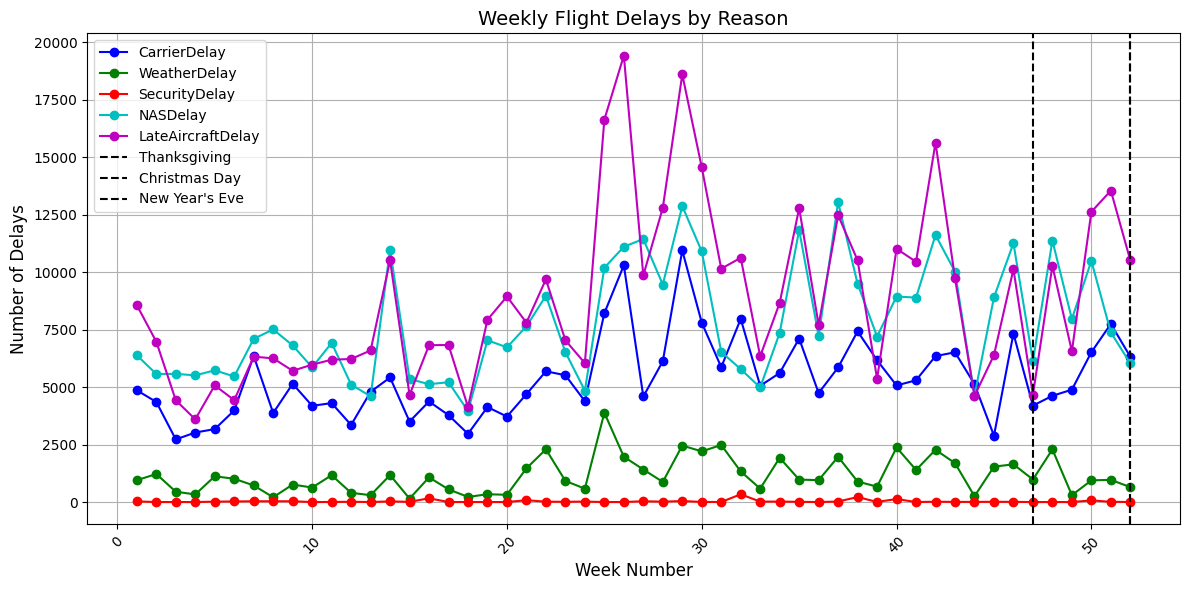

Top 10 Weeks with Highest Total Delays:
    Year  Week  TotalDelays
28  2006    29        44906
25  2006    26        42780
24  2006    25        38915
41  2006    42        35872
29  2006    30        35462
36  2006    37        33355
34  2006    35        32705
49  2006    50        30634
45  2006    46        30358
50  2006    51        29640


In [11]:
weekly_delays_by_reason['TotalDelays'] = weekly_delays_by_reason[delay_reasons].sum(axis=1)
top_weeks = weekly_delays_by_reason.nlargest(10, 'TotalDelays')


plt.figure(figsize=(12, 6))
colors = ['b', 'g', 'r', 'c', 'm']

for reason, color in zip(delay_reasons, colors):
    plt.plot(weekly_delays_by_reason['Week'], weekly_delays_by_reason[reason], 
             marker='o', linestyle='-', color=color, label=reason)


for _, row in top_weeks.iterrows():
    plt.annotate(f"{row['Week']}", 
                 (row['Week'], row['TotalDelays']),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center', 
                 color='red')


for holiday_str, holiday_name in holidays_2006.items():
    holiday_date = pd.to_datetime(holiday_str)  # Convert to datetime
    holiday_week = holiday_date.isocalendar().week  # Extract the ISO week number
    plt.axvline(x=holiday_week, color='k', linestyle='--', label=holiday_name)


plt.title('Weekly Flight Delays by Reason', fontsize=14)
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

plt.show()

print("Top 10 Weeks with Highest Total Delays:")
print(top_weeks[['Year', 'Week', 'TotalDelays']])


Further investigaation of the week 26 and week 29 was described in the report.

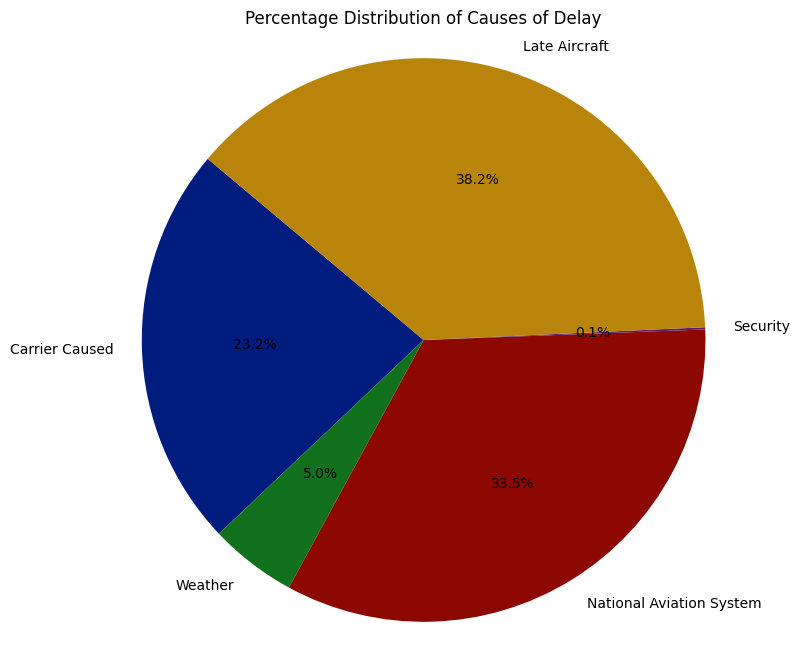

In [12]:
color_pie = sns.color_palette('dark6')
plt.figure(figsize=(8, 8))
plt.pie(df_delays['Percentage of Total Delay (%)'], 
        labels=df_delays['Delay Cause'], 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=color_pie)
plt.title('Percentage Distribution of Causes of Delay')
plt.axis('equal')
plt.show()

In [12]:
holidays_2006 = [{
    'November 23 Thursday (23/11/2006)': 'Thanksgiving',
    'December 25 Monday (25/12/2006)': 'Christmas Day',
    'December 31 Sunday (31/12/2006)': 'New Years Eve',
}]
pd.DataFrame(holidays_2006)

,November 23 Thursday (23/11/2006),December 25 Monday (25/12/2006),December 31 Sunday (31/12/2006)
0,Thanksgiving,Christmas Day,New Years Eve


In [13]:
def holiday_season(flight_data):
    """Instead of using Flight_date we encode if the date is last Thursday or Friday before a holiday/weekend."""

    holidays = ['10/11/2006', '17/11/2006', '21/11/2006', '22/11/2006', 
                '01/12/2006', '08/12/2006', '15/12/2006', '21/12/2006', 
                '22/12/2006', '23/12/2006', '24/12/2006', '28/12/2006', '29/12/2006']
    
    flight_date_str = flight_data.strftime('%d/%m/%Y')
    
    if flight_date_str in holidays:
        return True
    return False



In [14]:
df['InHolidayPeriod'] = df['FlightDate'].apply(holiday_season)

In [15]:
df

,Year,Quarter,Month,AirlineID,UniqueCarrier,Carrier,FlightDate,DayofMonth,DayOfWeek,Flights,...,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Week,InHolidayPeriod
0,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,NaN,0,0,0,0,0,0,2,False
1,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,NaN,0,0,0,0,0,0,2,False
2,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,NaN,0,0,0,0,0,16,2,False
3,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,NaN,0,0,0,0,0,0,2,False
4,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,NaN,0,0,0,0,0,0,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94939,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,0,NaN,0,0,0,0,0,0,52,True
94940,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,0,NaN,0,0,0,0,0,0,52,True
94941,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,0,NaN,0,0,0,0,0,0,52,True
94942,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,0,NaN,0,0,0,0,0,0,52,True


### InHolidayPeriod column is added to incorporate holiday seasons.

In [5]:
df.columns

Index(['Year', 'Quarter', 'Month', 'AirlineID', 'UniqueCarrier', 'Carrier',
       'FlightDate', 'DayofMonth', 'DayOfWeek', 'Flights', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDel15',
       'ArrDel30', 'ArrDelSys15', 'ArrDelSys30', 'ArrDelay', 'ArrTime',
       'ArrTimeBlk', 'CRSArrTime', 'DepDel15', 'DepDel30', 'DepDelSys15',
       'DepDelSys30', 'DepDelay', 'DepTime', 'DepTimeBlk', 'CRSDepTime',
       'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips',
       'OriginStateName', 'OriginWac', 'Dest', 'DestCityName', 'DestState',
       'DestStateFips', 'DestStateName', 'DestWac', 'Distance',
       'DistanceGroup', 'TaxiIn', 'TaxiOut', 'WheelsOff', 'WheelsOn',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [ ]:
#This cell is computationally costly.
aircrafts = {}
for tailnum in df['TailNum']:
    if tailnum not in aircrafts.keys():
        target_string = tailnum

        positions = df[df['TailNum'] == target_string].index.tolist()

        aircrafts[tailnum] = positions

### Repetitive Use of an Aircraft and its candidacy as a latent factor was examined.

In [103]:
aircraft_usage_count =  {tailnum: len(positions) for tailnum, positions in aircrafts.items()}
df['PreviousUsageCount'] = df.groupby('TailNum').cumcount()
df

,Year,Quarter,Month,AirlineID,UniqueCarrier,Carrier,FlightDate,DayofMonth,DayOfWeek,Flights,...,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Week,InHolidayPeriod,PreviousUsageCount
0,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,NaN,0,0,0,0,0,0,2,False,0
1,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,NaN,0,0,0,0,0,0,2,False,0
2,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,NaN,0,0,0,0,0,16,2,False,0
3,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,NaN,0,0,0,0,0,0,2,False,0
4,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,NaN,0,0,0,0,0,0,2,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94939,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,NaN,0,0,0,0,0,0,52,True,67
94940,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,NaN,0,0,0,0,0,0,52,True,52
94941,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,NaN,0,0,0,0,0,0,52,True,43
94942,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,NaN,0,0,0,0,0,0,52,True,44


In [ ]:
aircraft_usage = df.groupby('TailNum').size().reset_index(name='UsageCount')

aircraft_usage_sorted = aircraft_usage.sort_values(by='UsageCount', ascending=False)
aircraft_usage_sorted.head(40)

In [ ]:
plt.figure(figsize=(14, 7))

for tailnum in df['TailNum'].unique():

    aircraft_data = df[df['TailNum'] == tailnum]
    
    plt.plot(aircraft_data.index, aircraft_data['PreviousUsageCount'], label=tailnum)

plt.xlabel('Time (Index)', fontsize=12)
plt.ylabel('Previous Usage Count', fontsize=12)
plt.title('Aircraft Usage Over Time', fontsize=14)
#plt.legend(title='Tail Number', loc='upper right', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [20]:
df['ArrTimeBlk'].unique()

array(['1600-1659', '1700-1759', '1900-1959', '0700-0759', '2200-2259',
       '0900-0959', '1800-1859', '1400-1459', '2000-2059', '1100-1159',
       '2100-2159', '0600-0659', '1500-1559', '1000-1059', '0800-0859',
       '1200-1259', '2300-2359', '1300-1359', '0001-0559'], dtype=object)

In [21]:
df['DepTimeBlk'].unique()

array(['1500-1559', '1800-1859', '0600-0659', '2100-2159', '0700-0759',
       '1700-1759', '1300-1359', '1900-1959', '1000-1059', '1600-1659',
       '2000-2059', '1200-1259', '2200-2259', '0900-0959', '0800-0859',
       '1400-1459', '1100-1159', '2300-2359', '0001-0559'], dtype=object)

In [22]:
df[df['DepTimeBlk'] == '0001-0559'] #Only 18 values. This won't be visible to eye in the next graph.

,Year,Quarter,Month,AirlineID,UniqueCarrier,Carrier,FlightDate,DayofMonth,DayOfWeek,Flights,...,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Week,InHolidayPeriod
5130,2006,1,1.0,20355.0,US,US,2006-01-03,3,2,1,...,0,NaN,0,0,0,0,0,0,1,False
5248,2006,1,1.0,20355.0,US,US,2006-01-04,4,3,1,...,0,NaN,0,0,0,0,0,0,1,False
5370,2006,1,1.0,20355.0,US,US,2006-01-05,5,4,1,...,0,NaN,0,0,0,0,0,0,1,False
5496,2006,1,1.0,20355.0,US,US,2006-01-06,6,5,1,...,0,NaN,0,0,0,0,0,0,1,False
5583,2006,1,1.0,20355.0,US,US,2006-01-07,7,6,1,...,0,NaN,0,0,0,0,0,0,1,False
5822,2006,1,1.0,20355.0,US,US,2006-01-09,9,1,1,...,0,NaN,0,0,0,0,0,0,2,False
43206,2006,2,6.0,20355.0,US,US,2006-06-10,10,6,1,...,0,NaN,0,0,0,0,0,0,23,False
43207,2006,2,6.0,20355.0,US,US,2006-06-17,17,6,1,...,0,NaN,0,0,0,0,0,0,24,False
43208,2006,2,6.0,20355.0,US,US,2006-06-24,24,6,1,...,0,NaN,0,0,0,0,0,0,25,False
48463,2006,3,7.0,20355.0,US,US,2006-07-01,1,6,1,...,0,NaN,0,0,0,0,0,0,26,False


### Arrival and Departure Time blocks are binned into 4 categories.

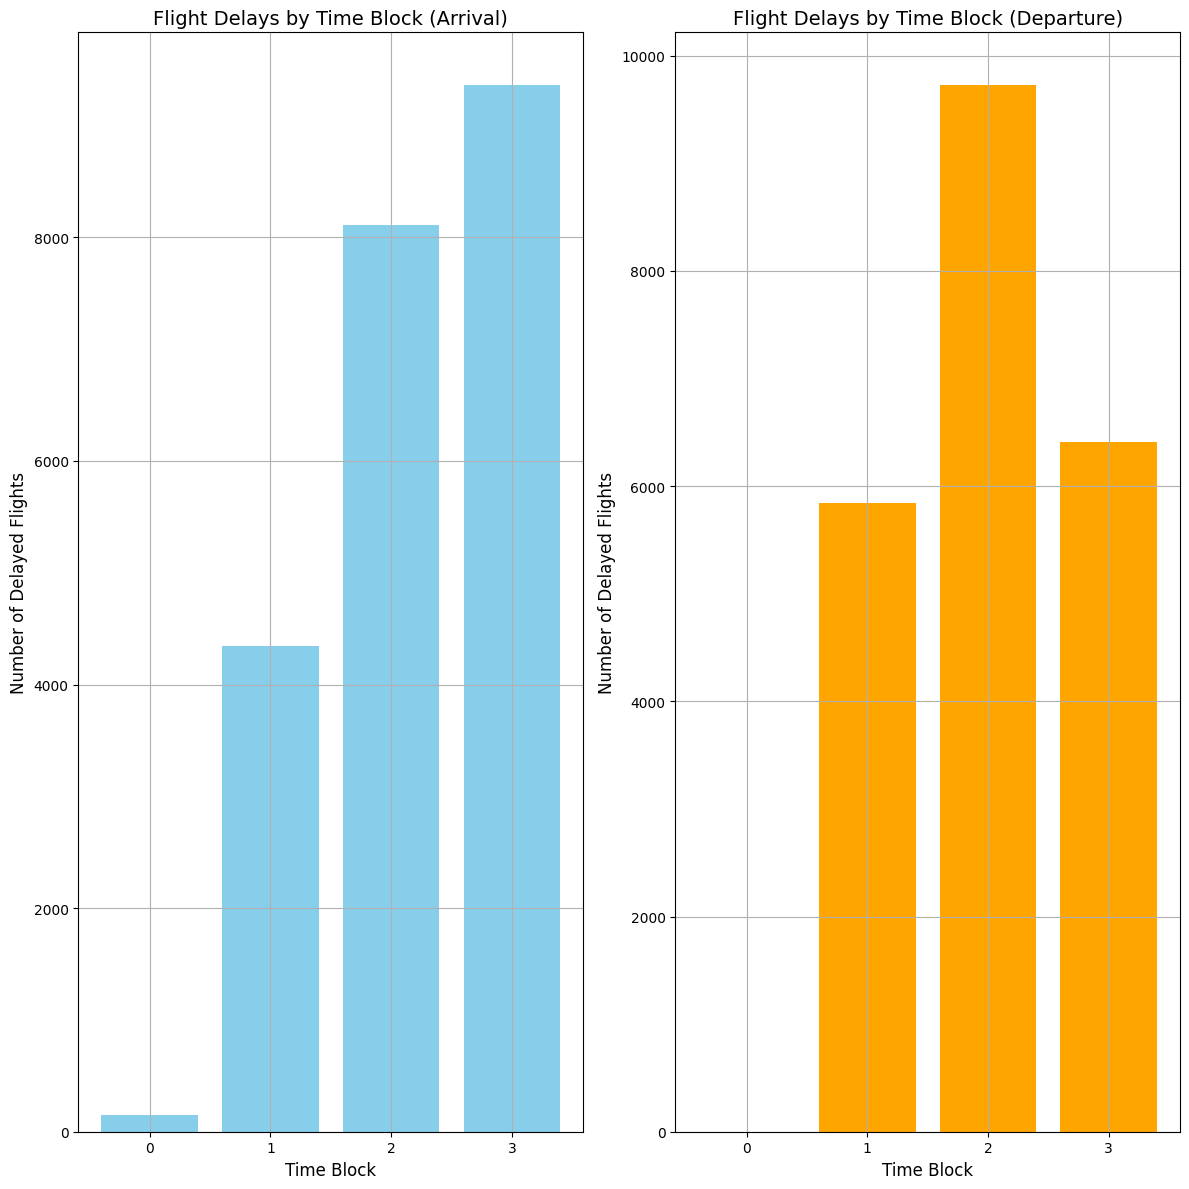

In [23]:
timeblock_map = {
    '0': [ '0001-0559'],  # 00:00 - 05:59
    '1': ['0600-0659', '0700-0759', '0800-0859', '0900-0959', '1000-1059', '1100-1159'],  # 06:00 - 11:59
    '2': ['1200-1259', '1300-1359', '1400-1459', '1500-1559', '1600-1659', '1700-1759'],  # 12:00 - 17:59
    '3': ['1800-1859', '1900-1959', '2000-2059', '2100-2159', '2200-2259', '2300-2359']   # 18:00 - 23:59
}

def get_timeblock_key(timeblock):
    #Map the time block to a quarter key.
    for key, values in timeblock_map.items():
        if timeblock in values:
            return key
    return None

def timeblock_encoder(data):
    #Encode the 'ArrTimeBlk' and 'DepTimeBlk' columns into timeblock categories
    timeblock_cols = ['ArrTimeBlk', 'DepTimeBlk']
    
    for col in timeblock_cols:
        data[col + '_Encoded'] = data[col].apply(lambda x: get_timeblock_key(x))
    
    return data

def encode_flight_data(data):
    data['Timestamp'] = pd.to_datetime(data['FlightDate']).astype('int64') / 1e9
    return data

df = encode_flight_data(df)
df = timeblock_encoder(df)

df['HasDelay'] = df[['CarrierDelay', 'WeatherDelay', 'SecurityDelay', 'NASDelay', 'LateAircraftDelay']].gt(0).any(axis=1)

timeblock_delays = df.groupby('ArrTimeBlk_Encoded')['HasDelay'].sum().reset_index()

all_timeblocks = ['0', '1', '2', '3']

timeblock_delays = timeblock_delays.set_index('ArrTimeBlk_Encoded').reindex(all_timeblocks, fill_value=0).reset_index()

timeblock_delays_departure = df.groupby('DepTimeBlk_Encoded')['HasDelay'].sum().reset_index()

timeblock_delays_departure = timeblock_delays_departure.set_index('DepTimeBlk_Encoded').reindex(all_timeblocks, fill_value=0).reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.bar(timeblock_delays['ArrTimeBlk_Encoded'], timeblock_delays['HasDelay'], color='skyblue')
ax1.set_title('Flight Delays by Time Block (Arrival)', fontsize=14)
ax1.set_xlabel('Time Block', fontsize=12)
ax1.set_ylabel('Number of Delayed Flights', fontsize=12)
ax1.grid(True)
ax2.bar(timeblock_delays_departure['DepTimeBlk_Encoded'], timeblock_delays_departure['HasDelay'], color='orange')
ax2.set_title('Flight Delays by Time Block (Departure)', fontsize=14)
ax2.set_xlabel('Time Block', fontsize=12)
ax2.set_ylabel('Number of Delayed Flights', fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()

### Airlines responsible for flights are inspected for carrier specific delay patterns.

In [24]:
from sklearn.preprocessing import LabelEncoder

def analyze_and_encode_airline_delays(df):
    avg_delay_per_airline = df.groupby('UniqueCarrier')['DepDelay'].mean().sort_values()
    delayed_flights_count = df.groupby('UniqueCarrier')['DepDel15'].sum()

    airline_delays = pd.DataFrame({
        'AverageDelay': avg_delay_per_airline,
        'DelayedFlightsCount': delayed_flights_count
    }).reset_index()

    label_encoder = LabelEncoder()
    airline_delays['UniqueCarrier_Encoded'] = label_encoder.fit_transform(airline_delays['UniqueCarrier'])

    encoding_explanation = {
        original: encoded for original, encoded in zip(
            airline_delays['UniqueCarrier'], airline_delays['UniqueCarrier_Encoded']
        )
    }

    # Plot the delayed flights count
    plt.figure(figsize=(12, 6))
    sns.barplot(x='UniqueCarrier', y='DelayedFlightsCount', data=airline_delays, palette='dark')
    plt.title('Number of Flights Delayed Over 15 Minutes per Airline', fontsize=16)
    plt.xlabel('Airline', fontsize=14)
    plt.ylabel('Number of Delayed Flights', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

    return airline_delays, encoding_explanation



C:\Users\bilge\AppData\Local\Temp\ipykernel_19344\408696576.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='UniqueCarrier', y='DelayedFlightsCount', data=airline_delays, palette='dark')


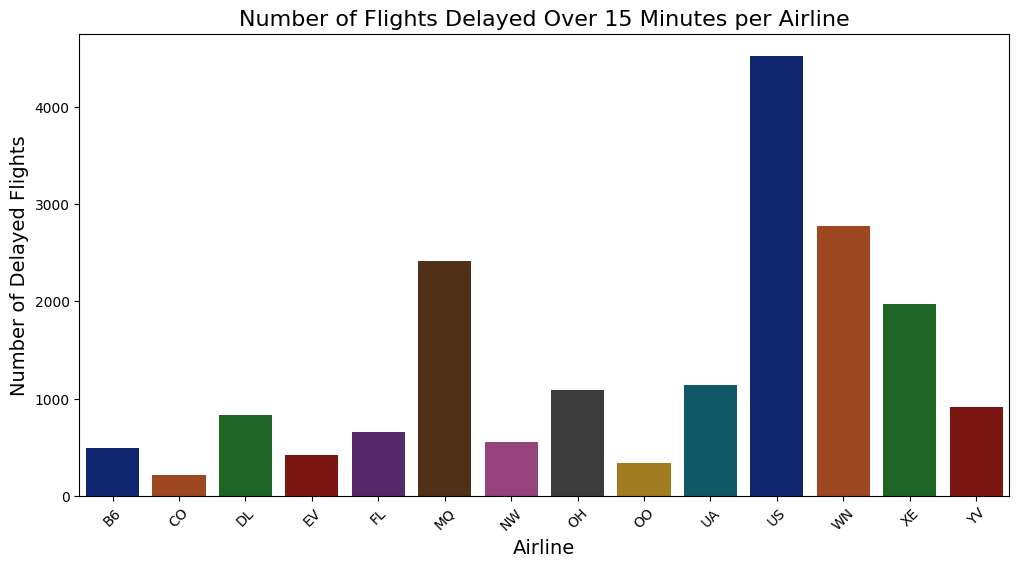

Airline Delays Summary:
   UniqueCarrier  AverageDelay  DelayedFlightsCount  UniqueCarrier_Encoded
0             B6     14.257103                  496                      0
1             CO      8.017201                  211                      1
2             DL      9.736880                  832                      2
3             EV     18.698548                  416                      3
4             FL      7.158169                  660                      4
5             MQ     14.114954                 2412                      5
6             NW      6.805876                  550                      6
7             OH      8.683896                 1088                      7
8             OO     11.543424                  333                      8
9             UA     15.920401                 1141                      9
10            US      5.576467                 4525                     10
11            WN     10.509994                 2771                     11
1

In [25]:
airline_delays, encoding_explanation = analyze_and_encode_airline_delays(df)

print("Airline Delays Summary:")
print(airline_delays)

print("\nEncoding Explanation:")
print(encoding_explanation)


In [26]:
import math

In [28]:
df['DepDelay'].max()

752.0

### Departure delays are binarized so that all delays starting from minute 15:00 are considered as delayed, encoded with 1.

C:\Users\bilge\AppData\Local\Temp\ipykernel_19344\570213572.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='DepDelayBinary', y=feature, palette=current_palette, ax=axes[idx])
C:\Users\bilge\AppData\Local\Temp\ipykernel_19344\570213572.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='DepDelayBinary', y=feature, palette=current_palette, ax=axes[idx])
C:\Users\bilge\AppData\Local\Temp\ipykernel_19344\570213572.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='DepDelayBinary', y=feature, p

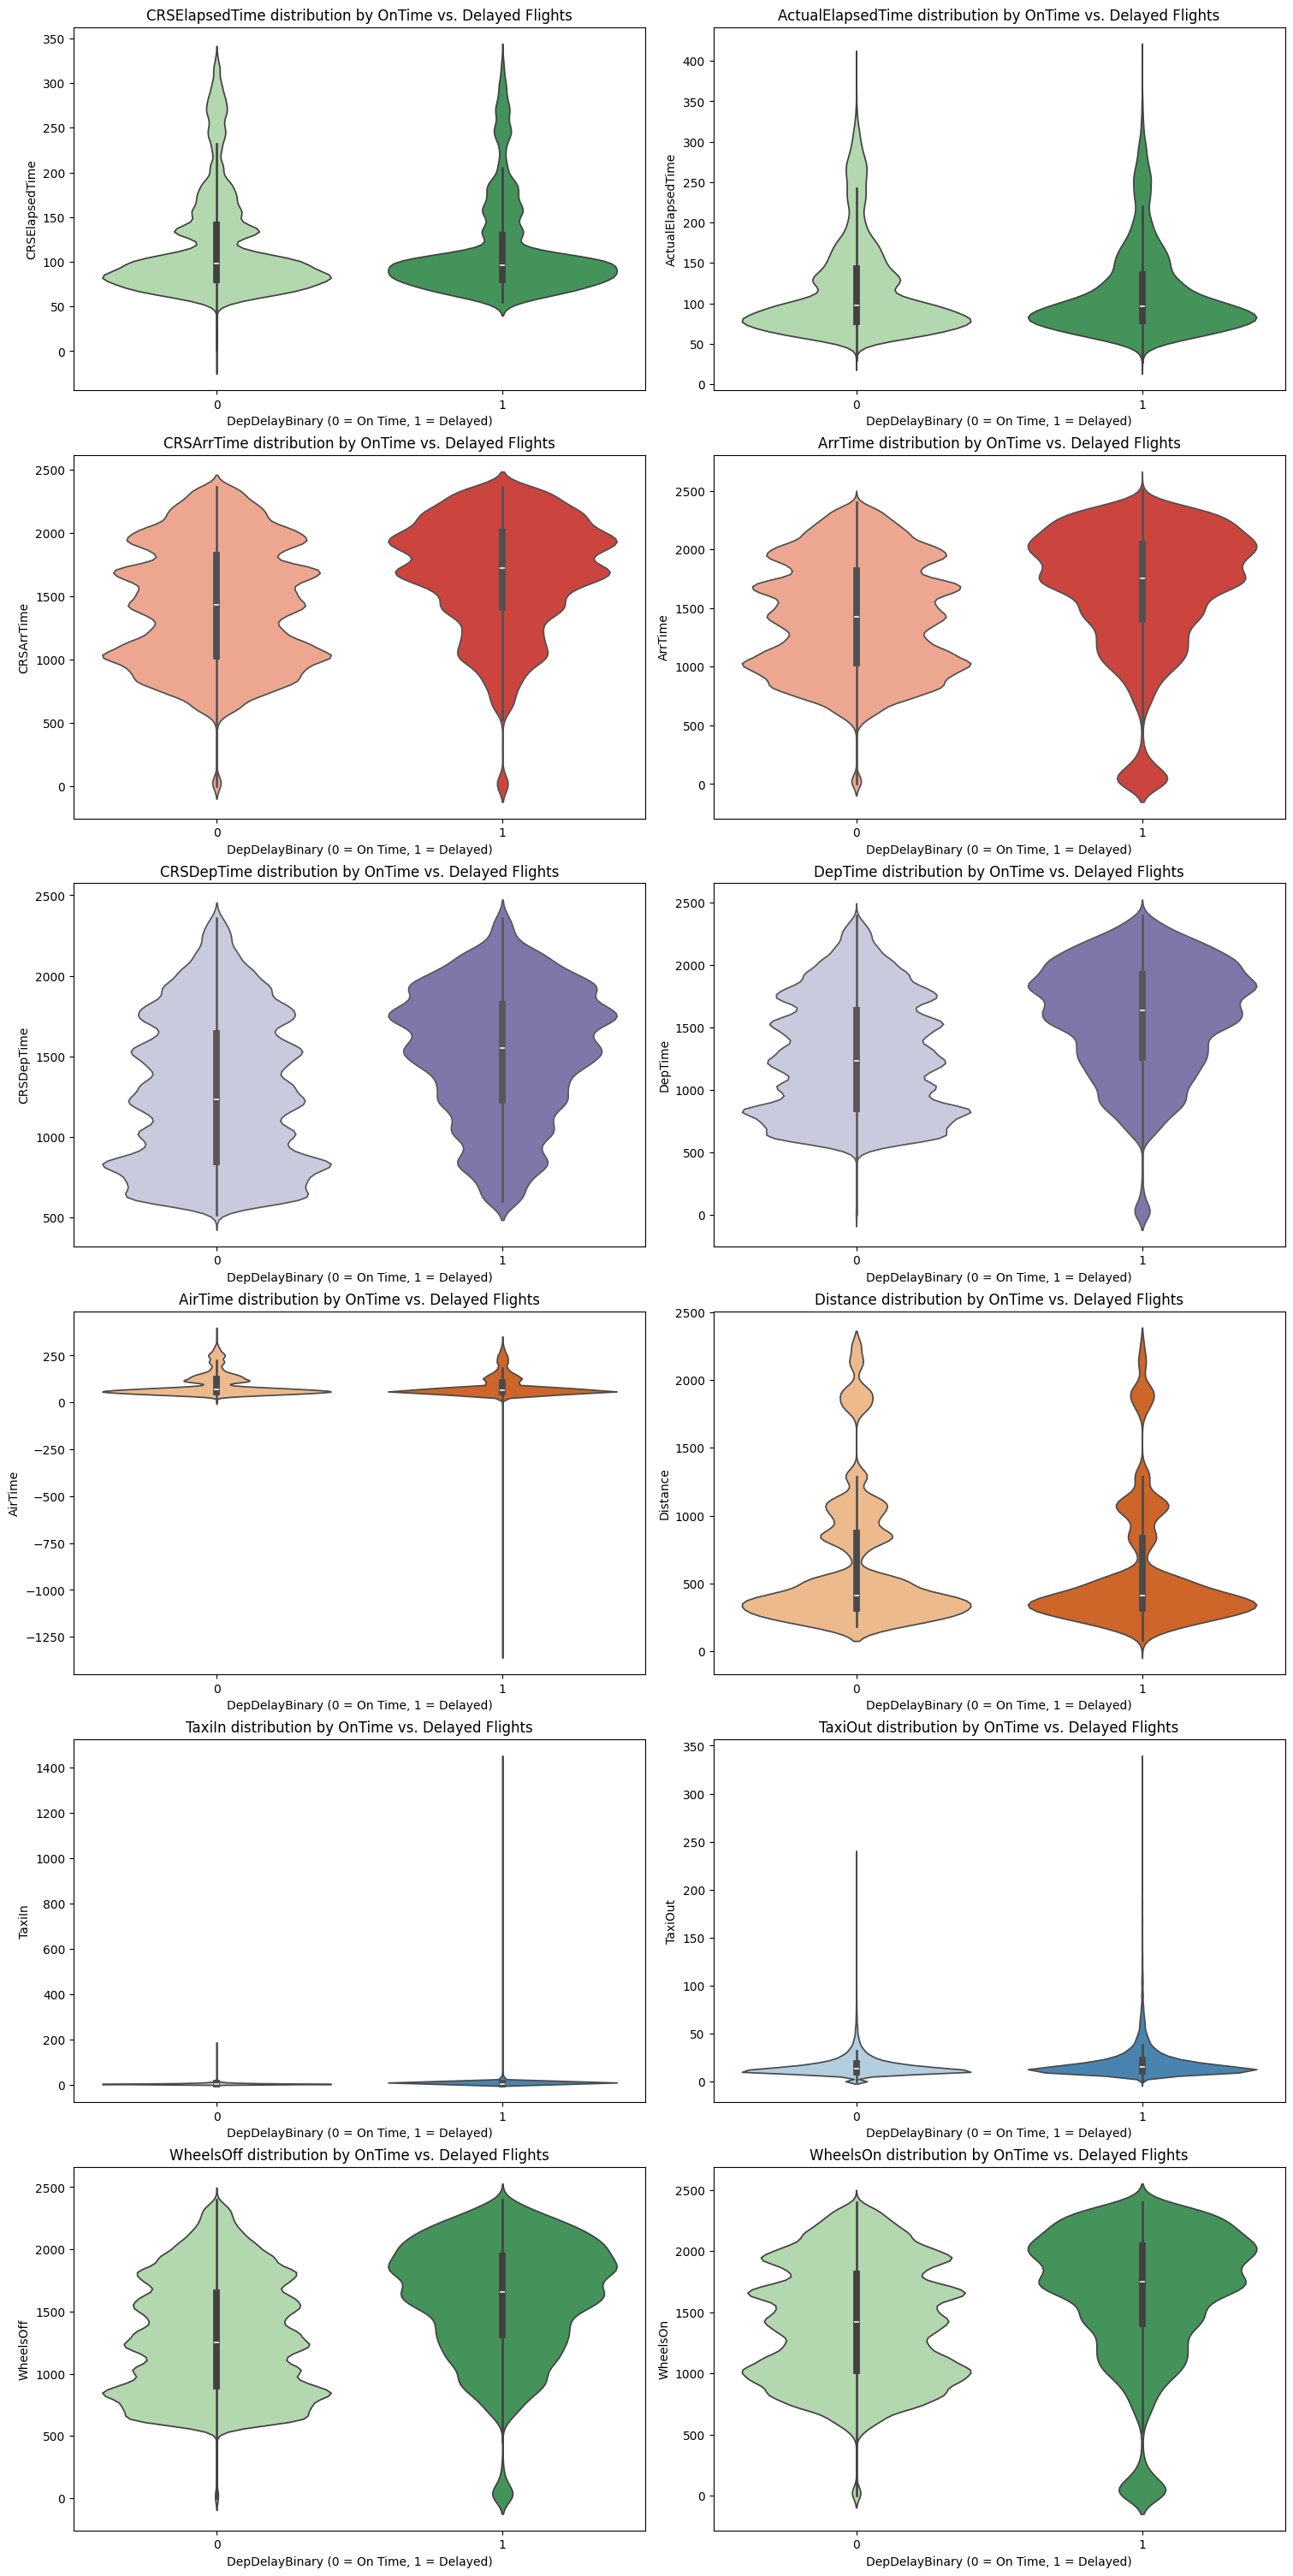

In [29]:
df['DepDelayBinary'] = (df['DepDelay'] >= 15).astype(int)


numerical_features = ['CRSElapsedTime',
                      'ActualElapsedTime',
                      'CRSArrTime',
                      'ArrTime',
                      'CRSDepTime',
                      'DepTime',
                      'AirTime',
                      'Distance',
                      'TaxiIn',
                      'TaxiOut',
                      'WheelsOff',
                      'WheelsOn']

num_features = len(numerical_features)

n_cols = 2
n_rows = math.ceil(num_features / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5), constrained_layout=True)

axes = axes.flatten()

color_palettes = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges']
palette_cycle = iter(color_palettes)

current_palette = next(palette_cycle)
for idx, feature in enumerate(numerical_features):
    if idx % 2 == 0:
        current_palette = next(palette_cycle, color_palettes[0])
        palette_cycle = iter(color_palettes) if current_palette == color_palettes[-1] else palette_cycle

    sns.violinplot(data=df, x='DepDelayBinary', y=feature, palette=current_palette, ax=axes[idx])
    axes[idx].set_title(f'{feature} distribution by OnTime vs. Delayed Flights')
    axes[idx].set_xlabel('DepDelayBinary (0 = On Time, 1 = Delayed)')
    axes[idx].set_ylabel(feature)

for i in range(len(numerical_features), len(axes)):
    axes[i].axis('off')

plt.show()


In [30]:
def plot_depdel_binary_vs_categories(df, categories):
    import math

    rows = math.ceil(len(categories) / 2)
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 5))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        mean_delay = df.groupby(category)['DepDelayBinary'].mean().sort_values(ascending=False)
        mean_delay_df = mean_delay.reset_index()

        sns.barplot(
            x=category,
            y='DepDelayBinary',
            palette='Set3',
            data=mean_delay_df,
            ax=axes[i]
        )
        axes[i].set_title(f"Proportion of Delayed Flights by {category}")
        axes[i].set_xlabel(category)
        axes[i].set_ylabel("Proportion of Delayed Flights")
        axes[i].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()


### Geographical variables, routes of the planes investigated by each other for delay related patterns.

C:\Users\bilge\AppData\Local\Temp\ipykernel_19344\2269165245.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\bilge\AppData\Local\Temp\ipykernel_19344\2269165245.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\bilge\AppData\Local\Temp\ipykernel_19344\2269165245.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\bilge\AppData\Local\Temp\ipykernel_19344\2269165245.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

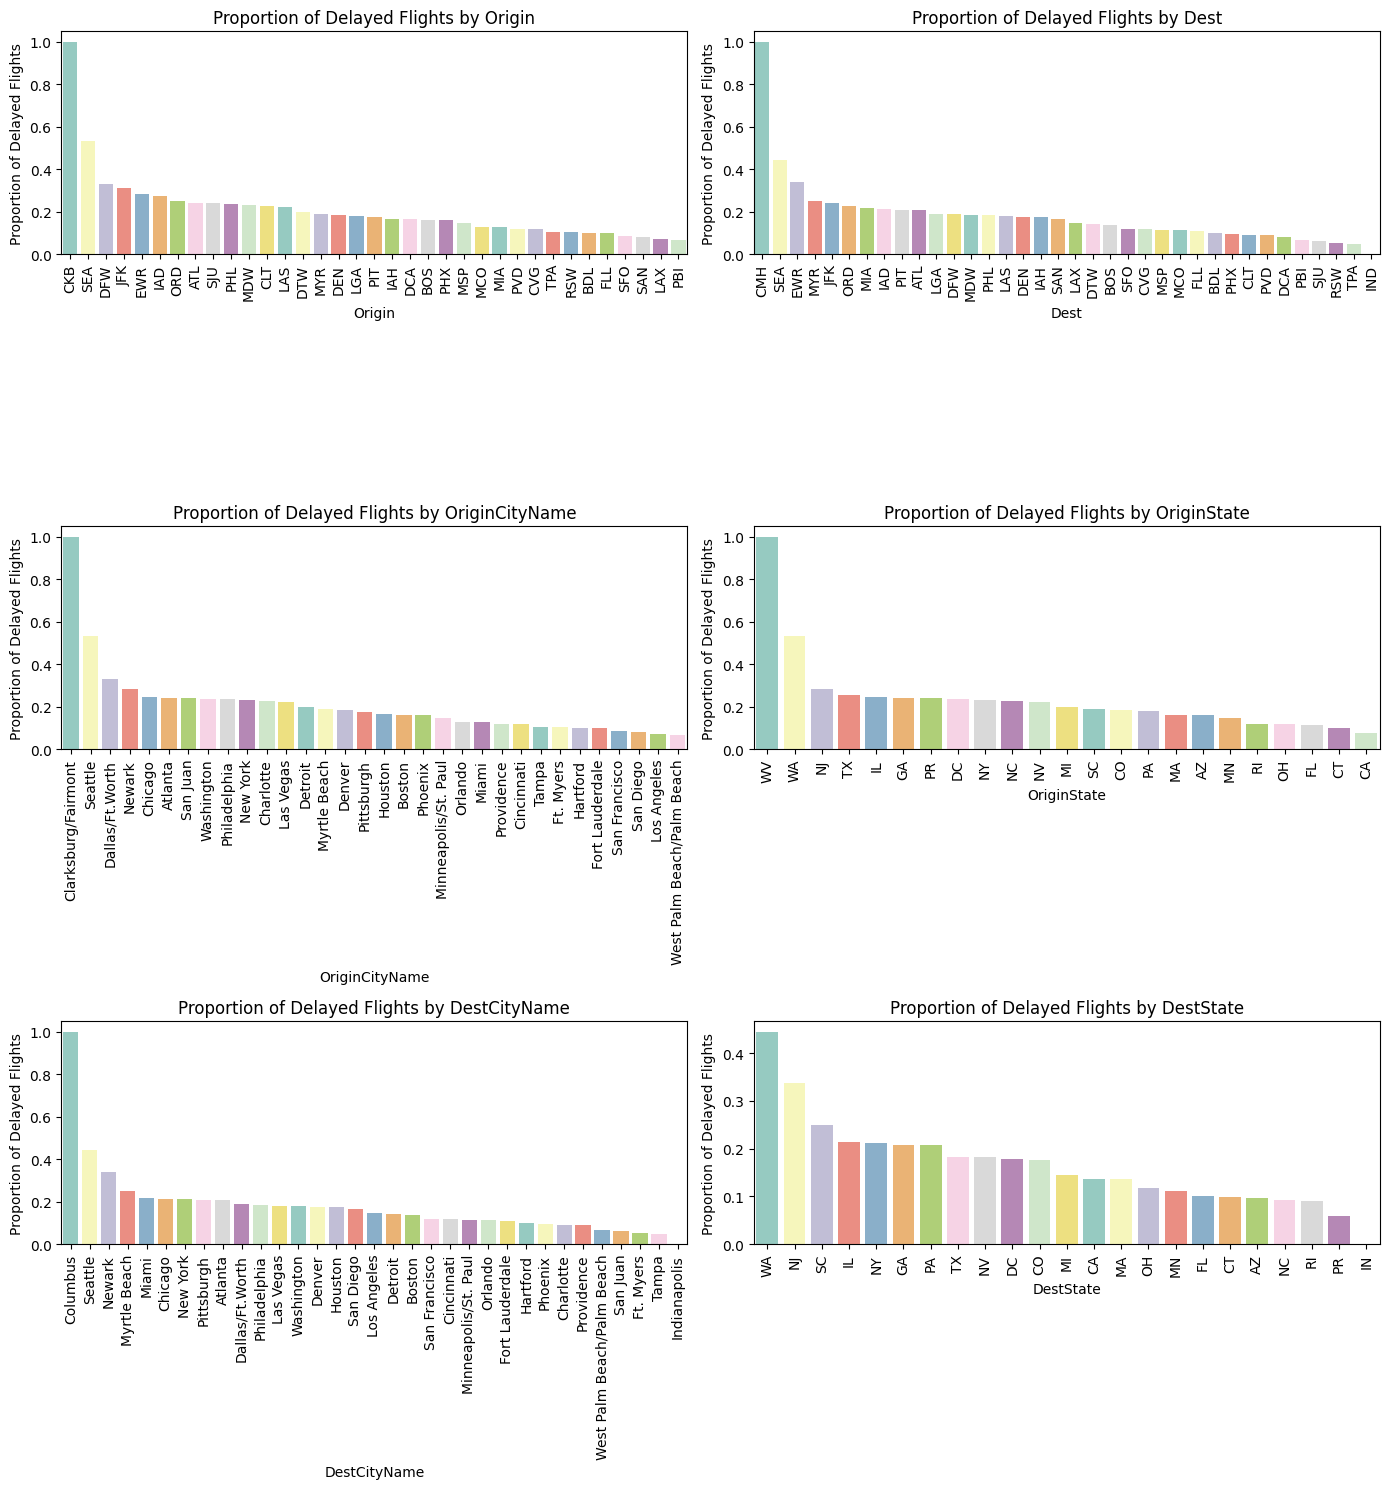

In [31]:
categories = ['Origin', 'Dest','OriginCityName', 'OriginState', 'DestCityName', 'DestState']
plot_depdel_binary_vs_categories(df, categories)

### Temporal variables (also categorical) were investigateed for delay related patterns.

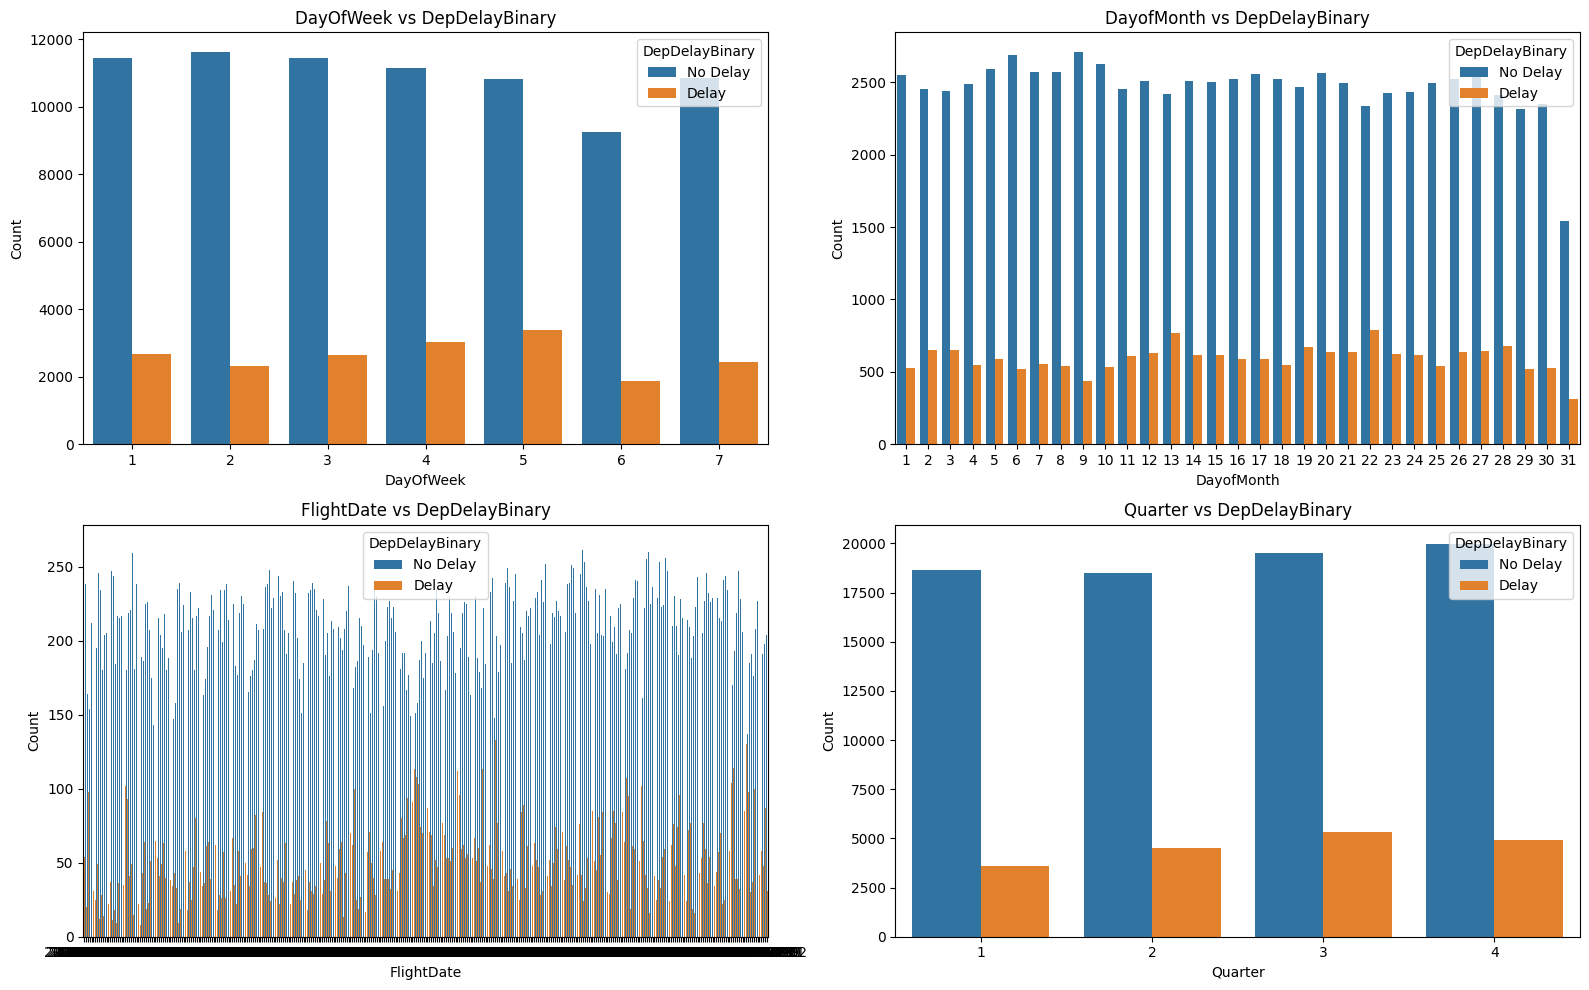

In [32]:
categories = ['DayOfWeek', 'DayofMonth', 'FlightDate', 'Quarter']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for ax, feature in zip(axes.flatten(), categories):
    sns.countplot(x=feature, hue='DepDelayBinary', data=df, ax=ax)
    ax.set_title(f'{feature} vs DepDelayBinary')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend(title='DepDelayBinary', labels=['No Delay', 'Delay'])

plt.tight_layout()
plt.show()

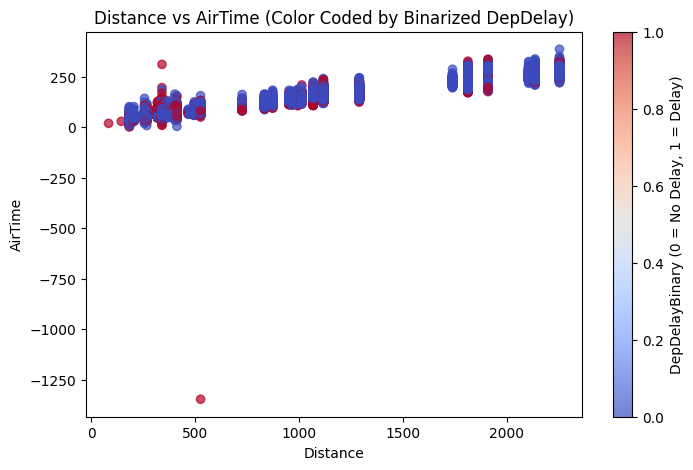

In [33]:
plt.figure(figsize=(8, 5))
plt.scatter(df['Distance'], df['AirTime'], c=df['DepDelayBinary'], cmap='coolwarm', alpha=0.7)
plt.title('Distance vs AirTime (Color Coded by Binarized DepDelay)')
plt.xlabel('Distance')
plt.ylabel('AirTime')
plt.colorbar(label='DepDelayBinary (0 = No Delay, 1 = Delay)')
plt.show()


In [126]:
df

,Year,Quarter,Month,AirlineID,UniqueCarrier,Carrier,FlightDate,DayofMonth,DayOfWeek,Flights,...,SecurityDelay,LateAircraftDelay,Week,InHolidayPeriod,PreviousUsageCount,Timestamp,ArrTimeBlk_Encoded,DepTimeBlk_Encoded,HasDelay,DepDelayBinary
0,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,0,2,False,0,1.136938e+09,2,2,False,0
1,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,0,2,False,0,1.136938e+09,2,2,False,1
2,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,16,2,False,0,1.136938e+09,3,3,True,1
3,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,0,2,False,0,1.136938e+09,1,1,False,0
4,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,0,2,False,0,1.136938e+09,3,3,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94939,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,0,0,52,True,67,1.167350e+09,3,3,False,1
94940,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,0,0,52,True,52,1.167350e+09,1,1,False,1
94941,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,0,0,52,True,43,1.167350e+09,2,2,False,1
94942,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,0,0,52,True,44,1.167350e+09,1,1,False,0


### Cancellation related features are dropped in order to prevent them to distille out truly predictive features.

In [34]:
def transform_data(df):
    
    delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
    df['TotalDelay'] = df[delay_columns].sum(axis=1, skipna=True)
    df.drop(columns=delay_columns, inplace=True)
    
    
    df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    df['Timestamp'] = df['FlightDate'].astype(np.int64) // 10**9  # Unix timestamp in seconds will be used instead of FlightDate format.
    
    df.drop(columns=['Year', 'Quarter', 'Month'], inplace=True, errors='ignore')
    
    columns_to_drop = ['Cancelled', 'CancellationCode', 'Diverted', 'HasDelay', 'DepDelayBinary', 'UniqueCarrier', 'Carrier', 'FlightDate']
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')


    categorical_columns = df.select_dtypes(include=['object']).columns
    label_encoder = LabelEncoder()
    
    for col in categorical_columns: 
        if df[col].dtype == 'object':
            df[col] = label_encoder.fit_transform(df[col])
    
    return df

In [35]:
df

,Year,Quarter,Month,AirlineID,UniqueCarrier,Carrier,FlightDate,DayofMonth,DayOfWeek,Flights,...,NASDelay,SecurityDelay,LateAircraftDelay,Week,InHolidayPeriod,Timestamp,ArrTimeBlk_Encoded,DepTimeBlk_Encoded,HasDelay,DepDelayBinary
0,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,0,0,2,False,1.136938e+09,2,2,False,0
1,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,0,0,2,False,1.136938e+09,2,2,False,0
2,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,0,16,2,False,1.136938e+09,3,3,True,1
3,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,0,0,2,False,1.136938e+09,1,1,False,0
4,2006,1,1.0,20355.0,US,US,2006-01-11,11,3,1,...,0,0,0,2,False,1.136938e+09,3,3,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94939,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,0,0,0,52,True,1.167350e+09,3,3,False,0
94940,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,0,0,0,52,True,1.167350e+09,1,1,False,0
94941,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,0,0,0,52,True,1.167350e+09,2,2,False,0
94942,2006,4,12.0,19790.0,DL,DL,2006-12-29,29,5,1,...,0,0,0,52,True,1.167350e+09,1,1,False,0


### An attempt to graph dependency network was made

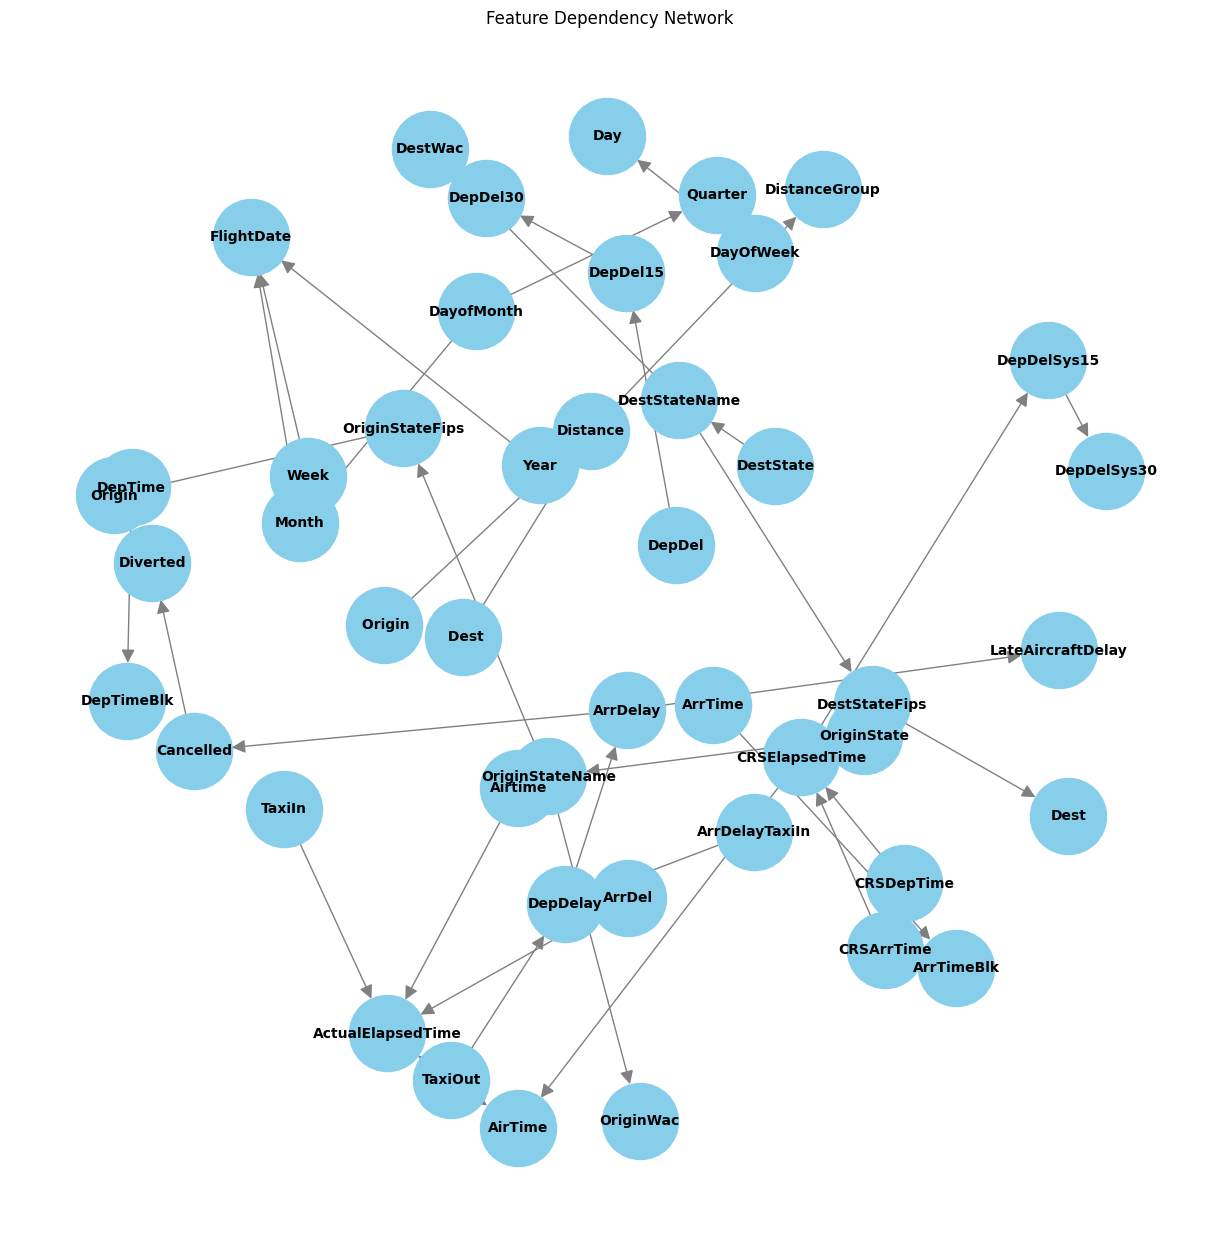

In [36]:
G = nx.DiGraph()

dependencies = {
    'Day' : ['DayOfWeek'],
    'Month' : ['DayofMonth'],
    'Quarter' : ['DayOfWeek', 'DayofMonth'],
    'FlightDate': ['Month', 'Year', 'Week'],  # FlightDate depends on these
    'CRSElapsedTime': ['CRSDepTime', 'CRSArrTime'],  # ArrDel30 depends on ArrDel15
    'Cancelled': ['ArrDelay'],  # Cancelled might depend on ArrDelay
    'Diverted': ['Cancelled'],  # Diverted depends on Cancelled status
    'ArrDelay': ['DepDelay'],  # ArrDelay might depend on DepDelay (e.g., late arrival due to late departure)
    'ArrTimeBlk' : ['ArrTime'],
    'DepDelay' : ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay' ],
    'LateAircraftDelay' : ['ArrDelay'],
    'DepTimeBlk' : ['DepTime'],
    'DepDel30' : ['DepDel15'],
    'DepDel15' : ['DepDel'],
    'DepDelSys30' : ['DepDelSys15'],
    'DepDelSys15' : ['CRSElapsedTime'],
    'DepDelay': ['ArrDelay''TaxiIn', 'TaxiOut', ],  # DepDelay might depend on taxiing time
    'DistanceGroup' : ['Distance'],
    'Distance': [' Origin', ' Dest'],
    'Dest': ['DestStateFips'],
    'DestStateFips':['DestStateName'],
    'DestWac' : ['DestStateName'],
    'DestStateName': ['DestState'],
    'Origin': ['OriginStateFips'],
    'OriginStateFips':['OriginStateName'],
    'OriginWac' : ['OriginStateName'],
    'OriginStateName': ['OriginState'],
    'AirTime': ['ActualElapsedTime', 'CRSElapsedTime'],
    'ActualElapsedTime': ['Airtime', 'ArrDel','TaxiIn', 'TaxiOut',],

}

for feature in dependencies:
    G.add_node(feature)
    for dependent in dependencies[feature]:
        G.add_edge(dependent, feature)

# Plot the graph
plt.figure(figsize=(12, 12))

# Using a shell layout to give a top-to-bottom structure
pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)

# Create the graph with labels and custom styling
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray", arrowsize=20)

# Set title
plt.title('Feature Dependency Network')
plt.show()

In [37]:
df.columns

Index(['Year', 'Quarter', 'Month', 'AirlineID', 'UniqueCarrier', 'Carrier',
       'FlightDate', 'DayofMonth', 'DayOfWeek', 'Flights', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDel15',
       'ArrDel30', 'ArrDelSys15', 'ArrDelSys30', 'ArrDelay', 'ArrTime',
       'ArrTimeBlk', 'CRSArrTime', 'DepDel15', 'DepDel30', 'DepDelSys15',
       'DepDelSys30', 'DepDelay', 'DepTime', 'DepTimeBlk', 'CRSDepTime',
       'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips',
       'OriginStateName', 'OriginWac', 'Dest', 'DestCityName', 'DestState',
       'DestStateFips', 'DestStateName', 'DestWac', 'Distance',
       'DistanceGroup', 'TaxiIn', 'TaxiOut', 'WheelsOff', 'WheelsOn',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'Week', 'InHolidayPeriod', 'Timestamp', 'ArrTimeBlk_Encoded',
       'DepTimeBlk_Encoded', 'HasDelay', 'DepDelayBinary'],
    

### BAsed on the observations and understanding based on the rabovementioned results, categorical and numerical columns too be inputed to the classifier were selected as the following: 

In [38]:
columns_to_include = [
    'AirlineID', 
    'DayofMonth', 
    'DayOfWeek', 
    'ActualElapsedTime', 
    'CRSElapsedTime',
    'AirTime',
    'ArrDelay', 
    'ArrTimeBlk', 
    'CRSArrTime',
    'DepTime',
    'DepTimeBlk', 
    'CRSDepTime',
    'Origin',
    'OriginCityName',
    'OriginState',
    'Dest',
    'DestCityName',
    'DestState',
    'DistanceGroup',
    'TaxiIn', 'TaxiOut',
    'InHolidayPeriod',
    'Timestamp',
    'ArrTimeBlk_Encoded',
    'DepTimeBlk_Encoded',
    'DepDelayBinary' #target
]

In [39]:
df_dropped = df[columns_to_include].copy()

In [40]:
df_dropped.dtypes

AirlineID             float64
DayofMonth              int64
DayOfWeek               int64
ActualElapsedTime     float64
CRSElapsedTime          int64
AirTime               float64
ArrDelay              float64
ArrTimeBlk             object
CRSArrTime              int64
DepTime               float64
DepTimeBlk             object
CRSDepTime              int64
Origin                 object
OriginCityName         object
OriginState            object
Dest                   object
DestCityName           object
DestState              object
DistanceGroup           int64
TaxiIn                  int64
TaxiOut                 int64
InHolidayPeriod          bool
Timestamp             float64
ArrTimeBlk_Encoded     object
DepTimeBlk_Encoded     object
DepDelayBinary          int32
dtype: object

In [41]:
import random

def k_folds_split(dataset, k):
    dataset_splits = [] #store the folds as arrays
    df_copy = dataset #keep the original dataset and modify this copy
    fold_size = int(len(df_copy) / k)

    for _ in range(k):

        fold_indices = random.sample(range(len(df_copy)), fold_size) #randomly select 'fold-size' long indices from the range of (0, len(df_copy))

        fold = [df_copy.iloc[idx].values.tolist() for idx in fold_indices] #populate the fold
        dataset_splits.append(np.asarray(fold)) 

    return dataset_splits      

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def cv(dataset, model, k):
    folds = k_folds_split(dataset, k)
    scores = []

    for i in range(k):

        validation_fold = folds[i] #remaining folds will be used as training set
        
        training_folds = np.concatenate([fold for j, fold in enumerate(folds) if j != i ], axis=0) 
        #decide a fold j is a training fold if j is not same as the i, validation fold.

        #train_test_split
        X_train_cv, y_train_cv = training_folds[:,:-1], training_folds[:, -1] #the last row, target row
        X_val_cv, y_val_cv = validation_fold[:,:-1], validation_fold[:,-1]

        X_train_scaled = scaler.fit_transform(X_train_cv)
        X_val_scaled = scaler.transform(X_val_cv)

        model.fit(X_train_scaled, y_train_cv)

        score = model.score(X_val_scaled, y_val_cv)
        scores.append(score)
    return np.mean(scores)

In [43]:
df_dropped

,AirlineID,DayofMonth,DayOfWeek,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,ArrTimeBlk,CRSArrTime,DepTime,...,DestCityName,DestState,DistanceGroup,TaxiIn,TaxiOut,InHolidayPeriod,Timestamp,ArrTimeBlk_Encoded,DepTimeBlk_Encoded,DepDelayBinary
0,20355.0,11,3,96.0,90,77.0,1.0,1600-1659,1650,1515.0,...,Pittsburgh,PA,2,5,14,False,1.136938e+09,2,2,0
1,20355.0,11,3,98.0,109,81.0,-7.0,1700-1759,1729,1544.0,...,Pittsburgh,PA,2,3,14,False,1.136938e+09,2,2,0
2,20355.0,11,3,108.0,111,83.0,16.0,1900-1959,1956,1824.0,...,Pittsburgh,PA,2,5,20,False,1.136938e+09,3,3,1
3,20355.0,11,3,111.0,105,85.0,0.0,0700-0759,750,559.0,...,Pittsburgh,PA,2,5,21,False,1.136938e+09,1,1,0
4,20355.0,11,3,73.0,85,59.0,-13.0,2200-2259,2255,2129.0,...,Pittsburgh,PA,2,4,10,False,1.136938e+09,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94939,19790.0,29,5,89.0,100,71.0,1.0,2000-2059,2047,1919.0,...,Pittsburgh,PA,3,8,10,True,1.167350e+09,3,3,0
94940,19790.0,29,5,107.0,117,80.0,-9.0,0900-0959,957,801.0,...,Atlanta,GA,3,9,18,True,1.167350e+09,1,1,0
94941,19790.0,29,5,110.0,107,83.0,6.0,1400-1459,1409,1225.0,...,Atlanta,GA,3,12,15,True,1.167350e+09,2,2,0
94942,19790.0,29,5,97.0,112,73.0,-17.0,1100-1159,1137,943.0,...,Pittsburgh,PA,3,3,21,True,1.167350e+09,1,1,0


In [44]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

categorical_columns = ['Origin', 'Dest', 'OriginCityName', 'DestCityName', 'OriginState', 'DestState', 'ArrTimeBlk_Encoded', 'DepTimeBlk_Encoded', 'InHolidayPeriod']
numerical_columns = ['AirlineID', 'ActualElapsedTime', 'AirTime', 'ArrDelay', 'CRSArrTime', 'DepTime', 'CRSDepTime', 'TaxiIn', 'TaxiOut', 'Timestamp']
target_column = 'DepDelayBinary'

X = df[categorical_columns + numerical_columns]
y = df[target_column]

# Step 1: Imputation
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

X[numerical_columns] = numerical_imputer.fit_transform(X[numerical_columns])
X[categorical_columns] = categorical_imputer.fit_transform(X[categorical_columns])

# Step 2: Get dummies for categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

C:\Users\bilge\AppData\Local\Temp\ipykernel_19344\203904426.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_columns] = numerical_imputer.fit_transform(X[numerical_columns])
C:\Users\bilge\AppData\Local\Temp\ipykernel_19344\203904426.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_columns] = categorical_imputer.fit_transform(X[categorical_columns])


In [45]:
X_encoded

,AirlineID,ActualElapsedTime,AirTime,ArrDelay,CRSArrTime,DepTime,CRSDepTime,TaxiIn,TaxiOut,Timestamp,...,DestState_SC,DestState_TX,DestState_WA,ArrTimeBlk_Encoded_1,ArrTimeBlk_Encoded_2,ArrTimeBlk_Encoded_3,DepTimeBlk_Encoded_1,DepTimeBlk_Encoded_2,DepTimeBlk_Encoded_3,InHolidayPeriod_True
0,20355.0,96.0,77.0,1.0,1650.0,1515.0,1520.0,5.0,14.0,1.136938e+09,...,False,False,False,False,True,False,False,True,False,False
1,20355.0,98.0,81.0,-7.0,1729.0,1544.0,1540.0,3.0,14.0,1.136938e+09,...,False,False,False,False,True,False,False,True,False,False
2,20355.0,108.0,83.0,16.0,1956.0,1824.0,1805.0,5.0,20.0,1.136938e+09,...,False,False,False,False,False,True,False,False,True,False
3,20355.0,111.0,85.0,0.0,750.0,559.0,605.0,5.0,21.0,1.136938e+09,...,False,False,False,True,False,False,True,False,False,False
4,20355.0,73.0,59.0,-13.0,2255.0,2129.0,2130.0,4.0,10.0,1.136938e+09,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94939,19790.0,89.0,71.0,1.0,2047.0,1919.0,1907.0,8.0,10.0,1.167350e+09,...,False,False,False,False,False,True,False,False,True,True
94940,19790.0,107.0,80.0,-9.0,957.0,801.0,800.0,9.0,18.0,1.167350e+09,...,False,False,False,True,False,False,True,False,False,True
94941,19790.0,110.0,83.0,6.0,1409.0,1225.0,1222.0,12.0,15.0,1.167350e+09,...,False,False,False,False,True,False,False,True,False,True
94942,19790.0,97.0,73.0,-17.0,1137.0,943.0,945.0,3.0,21.0,1.167350e+09,...,False,False,False,True,False,False,True,False,False,True


In [53]:
X_encoded.filter(like='Dep', axis=1)

,DepTime,CRSDepTime,DepTimeBlk_Encoded_1,DepTimeBlk_Encoded_2,DepTimeBlk_Encoded_3
0,1515.0,1520.0,False,True,False
1,1544.0,1540.0,False,True,False
2,1824.0,1805.0,False,False,True
3,559.0,605.0,True,False,False
4,2129.0,2130.0,False,False,True
...,...,...,...,...,...
94939,1919.0,1907.0,False,False,True
94940,801.0,800.0,True,False,False
94941,1225.0,1222.0,False,True,False
94942,943.0,945.0,True,False,False


In [58]:
#CRSDepTime corresponds to scheduled departure time, so this will be retained while everything else related to departure will be dropped.
X_encoded_without_Deps = X_encoded.drop(['DepTime','DepTimeBlk_Encoded_1','DepTimeBlk_Encoded_2','DepTimeBlk_Encoded_3'], axis=1)

In [59]:
X_encoded_without_Deps

,AirlineID,ActualElapsedTime,AirTime,ArrDelay,CRSArrTime,CRSDepTime,TaxiIn,TaxiOut,Timestamp,Origin_BDL,...,DestState_PA,DestState_PR,DestState_RI,DestState_SC,DestState_TX,DestState_WA,ArrTimeBlk_Encoded_1,ArrTimeBlk_Encoded_2,ArrTimeBlk_Encoded_3,InHolidayPeriod_True
0,20355.0,96.0,77.0,1.0,1650.0,1520.0,5.0,14.0,1.136938e+09,True,...,True,False,False,False,False,False,False,True,False,False
1,20355.0,98.0,81.0,-7.0,1729.0,1540.0,3.0,14.0,1.136938e+09,False,...,True,False,False,False,False,False,False,True,False,False
2,20355.0,108.0,83.0,16.0,1956.0,1805.0,5.0,20.0,1.136938e+09,False,...,True,False,False,False,False,False,False,False,True,False
3,20355.0,111.0,85.0,0.0,750.0,605.0,5.0,21.0,1.136938e+09,False,...,True,False,False,False,False,False,True,False,False,False
4,20355.0,73.0,59.0,-13.0,2255.0,2130.0,4.0,10.0,1.136938e+09,False,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94939,19790.0,89.0,71.0,1.0,2047.0,1907.0,8.0,10.0,1.167350e+09,False,...,True,False,False,False,False,False,False,False,True,True
94940,19790.0,107.0,80.0,-9.0,957.0,800.0,9.0,18.0,1.167350e+09,False,...,False,False,False,False,False,False,True,False,False,True
94941,19790.0,110.0,83.0,6.0,1409.0,1222.0,12.0,15.0,1.167350e+09,False,...,False,False,False,False,False,False,False,True,False,True
94942,19790.0,97.0,73.0,-17.0,1137.0,945.0,3.0,21.0,1.167350e+09,False,...,True,False,False,False,False,False,True,False,False,True


### RandomForestClassifier was tuned by 5-fold grid_search_cv. Best model was returned for making predictions and its feature importances.

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

rf_model_final = RandomForestClassifier(random_state=42)

param_grid_final = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5],
    'rf__bootstrap': [True, False]
}


pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('rf', rf_model_final)
])

grid_search_final = GridSearchCV(estimator=pipeline, param_grid=param_grid_final, cv=5, n_jobs=-1, verbose=2)

grid_search_final.fit(X_encoded_without_Deps, y)
best_model_final = grid_search_final.best_estimator_
#Check if model has a feature importances attribute, since some models use coeffienct.
if hasattr(best_model.named_steps['rf'], 'feature_importances_'):
    feature_importances = best_model_final.named_steps['rf'].feature_importances_
    feature_names = X_encoded_without_Deps.columns
    feature_importance_df_final = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print("Feature Importances:")
    print(feature_importance_df_final)
else:
    print("The best model does not have feature importances.")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Feature Importances:
                       Feature    Importance
3                     ArrDelay  5.974682e-01
1            ActualElapsedTime  7.176098e-02
7                      TaxiOut  5.904722e-02
2                      AirTime  4.852315e-02
8                    Timestamp  4.684612e-02
..                         ...           ...
101  OriginCityName_Providence  2.024653e-06
158             OriginState_RI  1.536753e-06
121  DestCityName_Indianapolis  2.516309e-07
170               DestState_IN  8.174593e-08
56                    Dest_IND  5.388232e-08

[189 rows x 2 columns]


In [72]:
feature_importance_df_final.head(15)

,Feature,Importance
3,ArrDelay,0.597468
1,ActualElapsedTime,0.071761
7,TaxiOut,0.059047
2,AirTime,0.048523
8,Timestamp,0.046846
4,CRSArrTime,0.036189
6,TaxiIn,0.032435
5,CRSDepTime,0.029013
0,AirlineID,0.009485
185,ArrTimeBlk_Encoded_1,0.008291


### Distributions for top 9 most important variables are plotted.

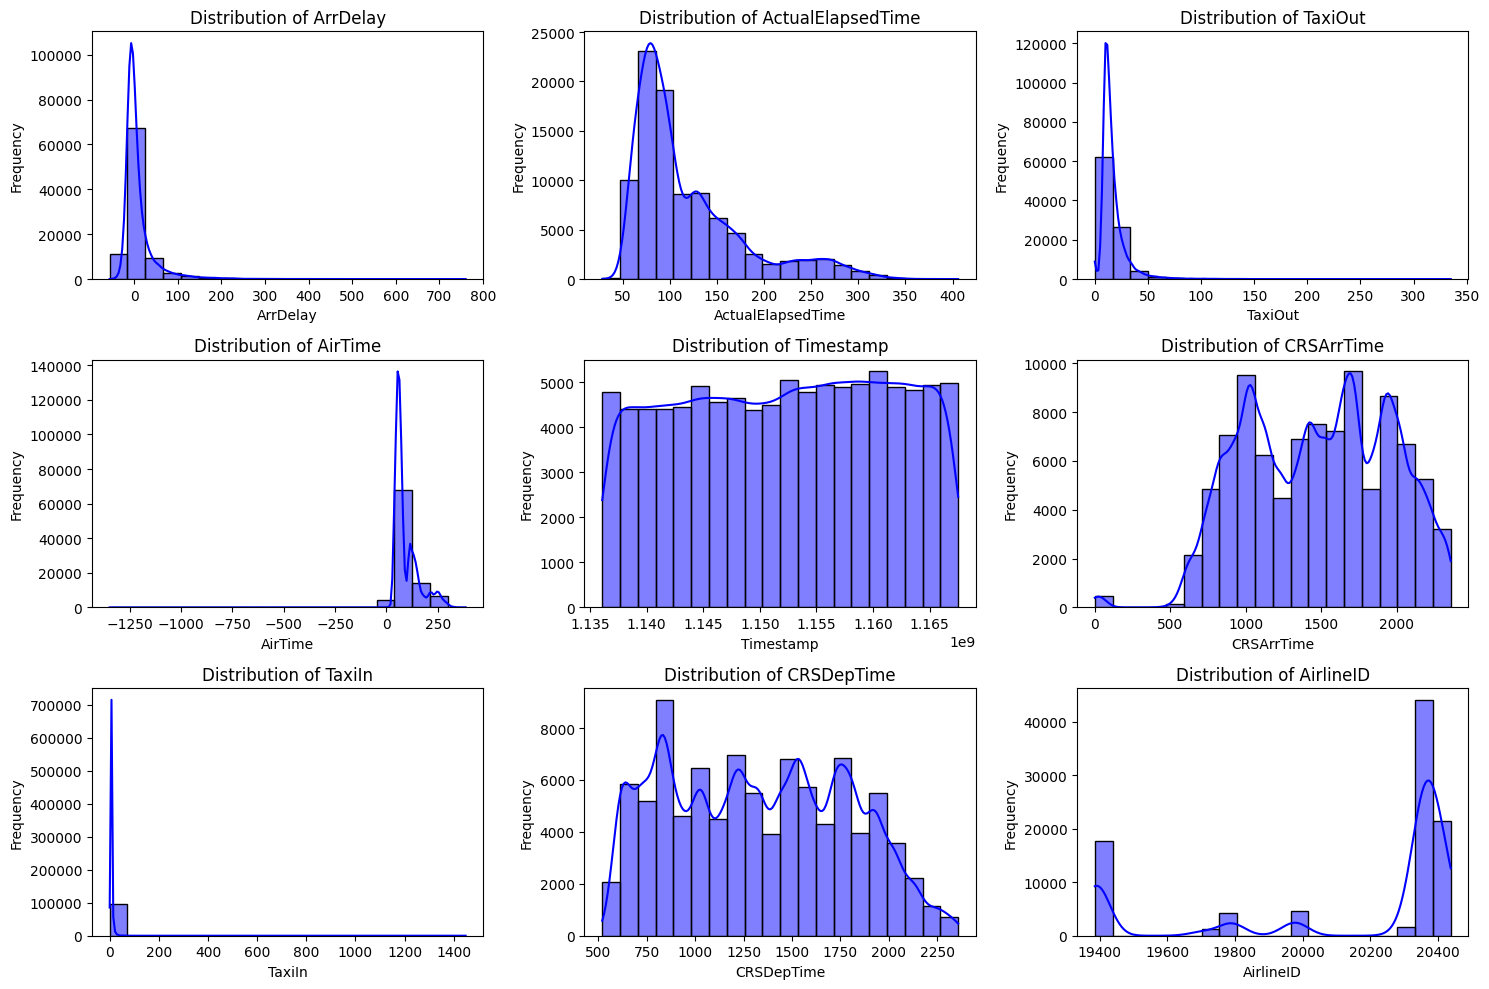

In [75]:
features_to_plot = ['ArrDelay', 'ActualElapsedTime', 'TaxiOut', 'AirTime', 'Timestamp', 'CRSArrTime', 'TaxiIn', 'CRSDepTime', 'AirlineID']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, color='blue', bins=20)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

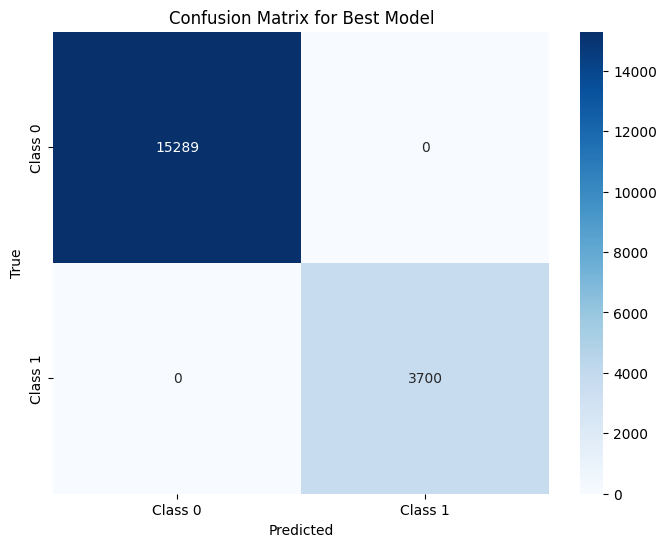

In [83]:
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_encoded_without_Deps, y, test_size=0.2, random_state=42)


y_pred = best_model_final.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Best Model')
plt.show()

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
ROC-AUC: 1.00

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     15289
     Class 1       1.00      1.00      1.00      3700

    accuracy                           1.00     18989
   macro avg       1.00      1.00      1.00     18989
weighted avg       1.00      1.00      1.00     18989



### Experiment: Since model has performed suspiciously well, another RandomForestClassifier was tested solely relying one the highest performing feature for predictions.

In [89]:
import kagglehub

path = kagglehub.dataset_download("mexwell/carrier-on-time-performance-dataset")

print("Path to dataset files:", path)

100%|██████████| 156M/156M [00:48<00:00, 3.36MB/s] 

Extracting files...


Path to dataset files: C:\Users\bilge\.cache\kagglehub\datasets\mexwell\carrier-on-time-performance-dataset\versions\1


In [94]:
data_path = r"C:\Users\bilge\OneDrive\Masaüstü\FINLAND\BAY1\airline_2m.csv"
df = pd.read_csv(data_path, encoding='ISO-8859-1')
print(df.head())

C:\Users\bilge\AppData\Local\Temp\ipykernel_19344\4063528571.py:2: DtypeWarning: Columns (69,76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, encoding='ISO-8859-1')


   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  1998        1      1           2          5  1998-01-02                NW   
1  2009        2      5          28          4  2009-05-28                FL   
2  2013        2      6          29          6  2013-06-29                MQ   
3  2010        3      8          31          2  2010-08-31                DL   
4  2006        1      1          15          7  2006-01-15                US   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     19386                          NW      N297US  ...   
1                     20437                          FL      N946AT  ...   
2                     20398                          MQ      N665MQ  ...   
3                     19790                          DL      N6705Y  ...   
4                     20355                          US      N504AU  ...   

   Div4WheelsOff  Div4TailNum  Div5Airport  Div5AirportID Div5

In [130]:
pd.set_option('display.max_columns', None)
print(df.columns)
df['DepDelayBinary'] = (df['DepDelay'] >= 15).astype(int)

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'DOT_ID_Reporting_Airline',
       'IATA_CODE_Reporting_Airline', 'Tail_Number',
       ...
       'Div5Airport', 'Div5AirportID', 'Div5AirportSeqID', 'Div5WheelsOn',
       'Div5TotalGTime', 'Div5LongestGTime', 'Div5WheelsOff', 'Div5TailNum',
       'DepDelayBinary', 'Reporting_Airline_Encoded'],
      dtype='object', length=111)


In [127]:
#'ArrDelay', 'ActualElapsedTime', 'TaxiOut', 'AirTime', 'Timestamp', 'CRSArrTime', 'TaxiIn', 'CRSDepTime', 'AirlineID'  were the highest rankind features.
columns_analogous = [
    'Reporting_Airline',        # Analogous to 'AirlineID'
    'DayofMonth',              
    'DayOfWeek',                
    'ActualElapsedTime',        
    'CRSElapsedTime',           
    'AirTime',                  
    'ArrDelay',                 
    'ArrTimeBlk',               
    'CRSArrTime',              
    'DepTime',                  
    'DepTimeBlk',               
    'CRSDepTime',               
    'Origin',                   
    'OriginCityName',           
    'OriginState',              
    'Dest',                     
    'DestCityName',             
    'DestState',                
    'DistanceGroup',            
    'TaxiIn',                   
    'TaxiOut',                      
    'DepDelayBinary'                  
]

In [131]:
df['DepDelayBinary']

0          1
1          0
2          0
3          0
4          1
          ..
1999995    0
1999996    0
1999997    0
1999998    0
1999999    0
Name: DepDelayBinary, Length: 2000000, dtype: int32

In [139]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
X = df[['ActualElapsedTime', 'ArrDelay']]
y = df['DepDelayBinary']
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[485037  14880]
 [ 30862  69221]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95    499917
           1       0.82      0.69      0.75    100083

    accuracy                           0.92    600000
   macro avg       0.88      0.83      0.85    600000
weighted avg       0.92      0.92      0.92    600000



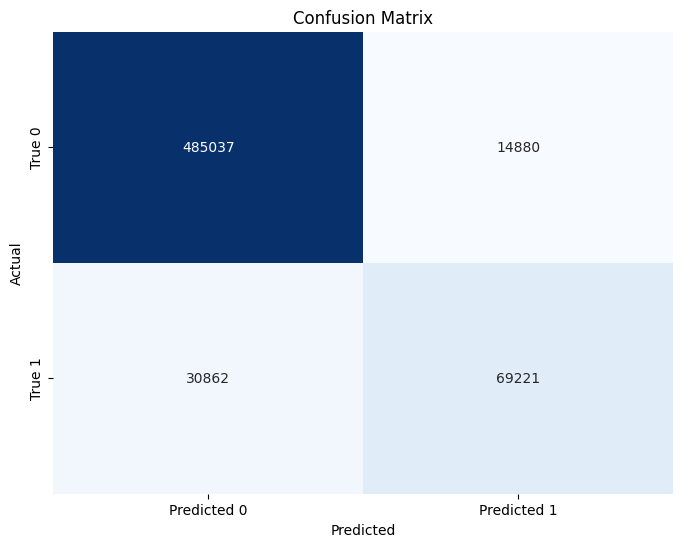

In [140]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()